## A study to demonstrate the most important predictors for the presence and number of solar panels in communities across the United States: Insights through classification and regression using SK-Learn.

### In order to answer this question of, "What are the key indicators for the absence of solar panels in an area?",  we will be utilizing the extensive deep solar dataset, compiled by Stanford Engineering in 2018. This dataset uses deep learning and satelite imagery to gather data on residential and non-residential solar installations in the United States, at the census-tract level. This data is then combined with a series of other demographic and meteorologic variables e.g. median age, average solar radiation, household income and voting patterns. The dataset is extensive, with over 72,000 rows and 169 columns. The initial question we look to answer while analyzing this dataset is, "What are the key indicators for the absence of solar panels in an area?". We aim to predict absence of solar panels because this is a more difficult prediction, most regions in the US have some solar panel penetration today, but what governs those that do not? Various classification methods were trialed for accuracy, before deciding that random forest produced the most accurate results - with an accuracy figure of greater than 80%. From this analysis feature importance was used to analyse which features contributed most heavily to this performance. Our second analysis is to compare those results of the feature importance from classification with regression, in order to determine whether those most important features that predict absence are consistent for predicting volume of solar panels. The results of this analysis could be of great importance for policy-makers and solar developers. The results of the classification outline the key barriers to promote greater solar adoption or break into a new market, whereas the regression results outline which features are most predictive of market growth. The workflow below demonstrates the results of our analysis and key conclusions.

In [1]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from sklearn.linear_model import LinearRegression as reg
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.ensemble import RandomForestRegressor as rf
import statsmodels.formula.api as smf
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns; sns.set(color_codes=True)
from sklearn.neighbors import KNeighborsClassifier as knnc
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  

from sklearn.metrics import classification_report, confusion_matrix  

### Our first step is to read in the Deep Solar dataset, and drop unwanted series.

In [2]:
df = pd.read_csv('deepsolar_tract.csv', encoding = 'latin-1')

In [3]:
df.shape

(72537, 169)

In [4]:
df = df.reset_index(drop=True)
df = df.drop('Unnamed: 0', axis=1)

### From the data-frame table below you can see the data is grouped by fips code - an 11 digit code that represents census tract.

In [5]:
df

,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,1757,...,39,11,13,34,0,0,25,12,0,9.46
1,25.0,21.0,1133.436461,27145011301,61727.085202,Stearns County,674,1434,108,767,...,39,11,13,34,0,0,25,12,0,9.46
2,3.0,3.0,64.505776,27145011302,71496.886583,Stearns County,854,1459,31,1541,...,39,11,13,34,0,0,25,12,0,9.46
3,0.0,0.0,0.000000,27145011304,86840.152755,Stearns County,640,1116,68,1095,...,39,11,13,34,0,0,25,12,0,9.46
4,5.0,5.0,164.583303,27145011400,89135.315597,Stearns County,654,1314,15,982,...,39,11,13,34,0,0,25,12,0,9.46
5,0.0,0.0,0.000000,27145011500,62225.903614,Stearns County,522,1395,24,1894,...,39,11,13,34,0,0,25,12,0,9.46
6,2.0,2.0,25.299013,27145011600,41068.936170,Stearns County,49,278,32,119,...,39,11,13,34,0,0,25,12,0,9.46
7,0.0,0.0,0.000000,27145010500,74073.833671,Stearns County,242,867,10,1118,...,39,11,13,34,0,0,25,12,0,9.46
8,0.0,0.0,0.000000,27145011100,69412.192435,Stearns County,527,1665,6,2031,...,39,11,13,34,0,0,25,12,0,9.46
9,11.0,10.0,415.365350,27145010102,82502.407069,Stearns County,1582,1949,6,1145,...,39,11,13,34,0,0,25,12,0,9.46


In [6]:
list(df)

['tile_count',
 'solar_system_count',
 'total_panel_area',
 'fips',
 'average_household_income',
 'county',
 'education_bachelor',
 'education_college',
 'education_doctoral',
 'education_high_school_graduate',
 'education_less_than_high_school',
 'education_master',
 'education_population',
 'education_professional_school',
 'employed',
 'gini_index',
 'heating_fuel_coal_coke',
 'heating_fuel_electricity',
 'heating_fuel_fuel_oil_kerosene',
 'heating_fuel_gas',
 'heating_fuel_housing_unit_count',
 'heating_fuel_none',
 'heating_fuel_other',
 'heating_fuel_solar',
 'land_area',
 'per_capita_income',
 'population',
 'population_density',
 'poverty_family_below_poverty_level',
 'poverty_family_count',
 'race_asian',
 'race_black_africa',
 'race_indian_alaska',
 'race_islander',
 'race_other',
 'race_two_more',
 'race_white',
 'state',
 'total_area',
 'unemployed',
 'water_area',
 'education_less_than_high_school_rate',
 'education_high_school_graduate_rate',
 'education_college_rate',
 '

### Given the large number of series, a reduced dataset was created that retained only those variables hypothesized to be the most predictive, as well as variables required for locational purposes.

In [7]:
df = df[['tile_count','state','household_count','fips',
        'county','population','age_median','land_area','employ_rate','per_capita_income',
         'average_household_income','median_household_income',
         'number_of_years_of_education','gini_index','diversity',
        'daily_solar_radiation','occupancy_owner_rate',
         'housing_unit_median_value','voting_2016_dem_percentage','voting_2016_gop_percentage',
         'voting_2012_dem_percentage','voting_2012_gop_percentage','lat','lon']]

### A final list of columns was then generated and is displayed below.

In [8]:
list(df)

['tile_count',
 'state',
 'household_count',
 'fips',
 'county',
 'population',
 'age_median',
 'land_area',
 'employ_rate',
 'per_capita_income',
 'average_household_income',
 'median_household_income',
 'number_of_years_of_education',
 'gini_index',
 'diversity',
 'daily_solar_radiation',
 'occupancy_owner_rate',
 'housing_unit_median_value',
 'voting_2016_dem_percentage',
 'voting_2016_gop_percentage',
 'voting_2012_dem_percentage',
 'voting_2012_gop_percentage',
 'lat',
 'lon']

In [9]:
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

## Exploratory Data Analysis

### Prior to starting this analysis theoretical relationships for the inital classification portion of this study were proposed. It was decided our dependent variable would be "tile_count" representing the number of tiles in any one census tract. A selection of 12 features were included as independent variables, namely: "age_median", "average_household_income", "daily_solar_radiation", "number_of_years_of_education", "population", "land_area','employ_rate", "gini_index", "diversity", "occupancy_owner_rate", "housing_unit_median_value" and "voting_2016_dem_percentage". It was hypothesised that features: age, household income, education and daily solar radiation would have the greatest impact on our dependent variable. 

### Before we begin, we must first turn our dependent variable into a binominal variable: 0 = No solar panels, 1 = has solar panels, so we can conduct the classification workflows.

In [10]:
df['tile_count_D'] = np.where(df['tile_count']==0, 0, 1)

### Furthermore, as this is a large data-set, a sample dataset of 10000 rows was created in order to more clearly visualize the relationships.

In [11]:
df_sample=df.sample(10000)

### The lines of code below demonstrate four logistic regression plots between our hypothesized 'key' features and our binomial dependent variable.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


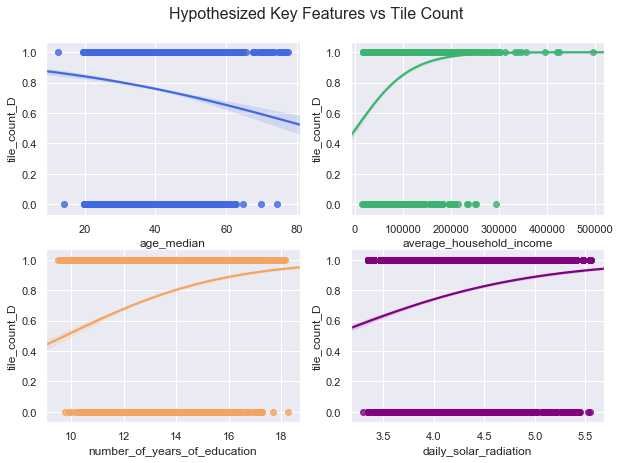

In [12]:
plt.rcParams["figure.figsize"] = [10,7]

plt.subplot(221)
sns.regplot(x="age_median", y="tile_count_D", data=df_sample, logistic=True, n_boot=500, color='royalblue')
#plt.ylim(0,250)

plt.subplot(222)
sns.regplot(x="average_household_income", y="tile_count_D", data=df_sample, logistic=True, n_boot=500, color='mediumseagreen')
#plt.ylim(0,250)

plt.subplot(223)
sns.regplot(x="number_of_years_of_education", y="tile_count_D", data=df_sample, logistic=True, n_boot=500, color='sandybrown')
#plt.ylim(0,250)

plt.subplot(224)
sns.regplot(x="daily_solar_radiation", y="tile_count_D", data=df_sample, logistic=True, n_boot=500, color='purple')
#plt.ylim(0,250)

plt.suptitle('Hypothesized Key Features vs Tile Count', y=.95,size=16)
plt.show()

### The logistic relationships outlined above demonstrate that tile count increases with increasing; number of years of education, daily solar radiation and average household income. This is to be expected. However, it appears that with increasing age tile count is predicted to decrease, perhaps a somewhat surprising relationship. This could be because younger generations are more eager to adopt new technologies. Let's observe whether these relationships hold during our correlation matrix below:

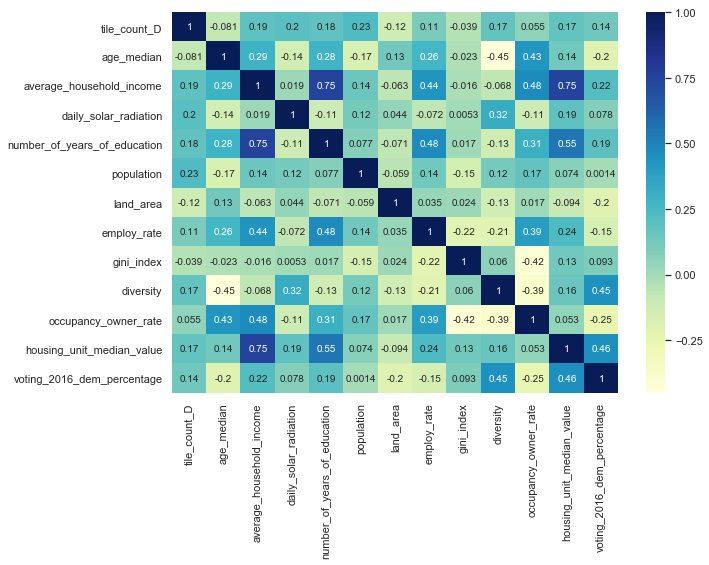

In [13]:
Var_Corr = df[['tile_count_D','age_median','average_household_income','daily_solar_radiation','number_of_years_of_education',
   'population','land_area','employ_rate','gini_index','diversity','occupancy_owner_rate',
   'housing_unit_median_value','voting_2016_dem_percentage']].corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, cmap="YlGnBu", annot=True)

### Further relationships are depicted in the correlation matrix above. As demonstrated in our logistic regression plots income, radiation and education have positive correlations with tile count. Other positive correlations of note are population, diversity, housing unit value and percent voting Democrat in the 2016 Presidential Election. Whereas, age, land area and the Gini Index are negatively correlated with tile count. 

### To analyze these relationships further our first method of analysis is logistic regression.

In [14]:
X = df[['household_count',
 'population',
 'age_median',
 'land_area',
 'employ_rate',
 'median_household_income',
 'number_of_years_of_education',
 'gini_index',
 'diversity',
 'daily_solar_radiation',
 'occupancy_owner_rate',
 'housing_unit_median_value',
 'voting_2016_dem_percentage']]

y = df.tile_count_D

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

### First our independent and dependent variables were defined based on the analysis above, and these were split in training and testing sets.

In [16]:
logreg = LogisticRegression()

logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [17]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[   72,  3102],
       [   69, 10529]])

### In the output 69 and 10529 are actual predictions and 72 and 3102 are wrong predictions.

In [18]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7697502178332849
Precision: 0.7724304893258015
Recall: 0.99348933761087


### The classification rate of 77% speaks for a good accuracy. The model is 77% precise, meaning that whenever it predicts that there will be solar panels, there is a 77% chance that there will actually be solar panels.

### Now lets use K Nearest Neighbors to see if we can improve on this accuracy rating. 

In [59]:
df['tile_count_Z'] = (df['tile_count']-df['tile_count'].mean())/df['tile_count'].std()
df['household_count_Z'] = (df['household_count']-df['household_count'].mean())/df['household_count'].std()
df['population_Z'] = (df['population']-df['population'].mean())/df['population'].std()
df['age_median_Z'] = (df['age_median']-df['age_median'].mean())/df['age_median'].std()
df['land_area_Z'] = (df['land_area']-df['land_area'].mean())/df['land_area'].std()
df['employ_rate_Z'] = (df['employ_rate']-df['employ_rate'].mean())/df['employ_rate'].std()
df['median_household_income_Z'] = (df['median_household_income']-df['median_household_income'].mean())/df['median_household_income'].std()
df['number_of_years_of_education_Z'] = (df['number_of_years_of_education']-df['number_of_years_of_education'].mean())/df['number_of_years_of_education'].std()
df['gini_index_Z'] = (df['gini_index']-df['gini_index'].mean())/df['gini_index'].std()
df['diversity_Z'] = (df['diversity']-df['diversity'].mean())/df['diversity'].std()
df['daily_solar_radiation_Z'] = (df['daily_solar_radiation']-df['daily_solar_radiation'].mean())/df['daily_solar_radiation'].std()
df['occupancy_owner_rate_Z'] = (df['occupancy_owner_rate']-df['occupancy_owner_rate'].mean())/df['occupancy_owner_rate'].std()
df['housing_unit_median_value_Z'] = (df['housing_unit_median_value']-df['housing_unit_median_value'].mean())/df['housing_unit_median_value'].std()
df['voting_2016_dem_percentage_Z'] = (df['voting_2016_dem_percentage']-df['voting_2016_dem_percentage'].mean())/df['voting_2016_dem_percentage'].std()

In [20]:
X = df[['household_count_Z',
 'population_Z',
 'age_median_Z',
 'land_area_Z',
 'employ_rate_Z',
 'median_household_income_Z',
 'number_of_years_of_education_Z',
 'gini_index_Z',
 'diversity_Z',
 'daily_solar_radiation_Z',
 'occupancy_owner_rate_Z',
 'housing_unit_median_value_Z',
 'voting_2016_dem_percentage_Z']]

y = df.tile_count_D

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [22]:
classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [23]:
y_pred = classifier.predict(X_test)  

In [24]:
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[1307 1867]
 [1104 9494]]
              precision    recall  f1-score   support

           0       0.54      0.41      0.47      3174
           1       0.84      0.90      0.86     10598

   micro avg       0.78      0.78      0.78     13772
   macro avg       0.69      0.65      0.67     13772
weighted avg       0.77      0.78      0.77     13772



### The results demonstrate there are 3174 cases of non-solar (0) were predicted with a precision of 54%, while 10598 cases of solar (1) were predicted with a precision of 84%. Which returns a weighted average of 77%, however demonstrates that when attemtping to predict areas where there is no solar we are still only slightly better off than flipping a coin.

### Can this analysis then be refined by changing the value for K?

In [25]:
error = []

for i in range(40, 80):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

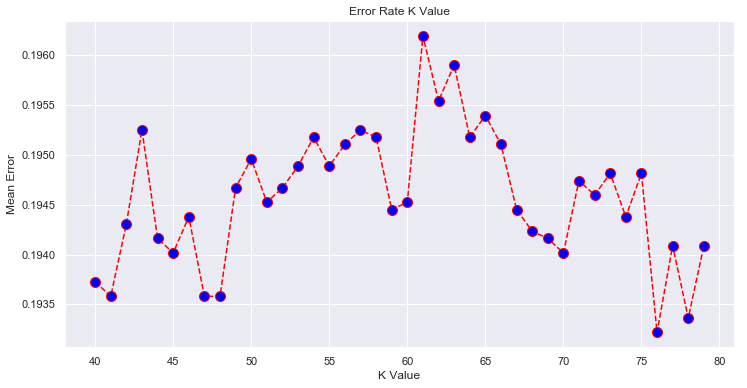

In [26]:
plt.figure(figsize=(12, 6))  
plt.plot(range(40, 80), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

### After a brief preliminary screening, the graph above demonstrates that the optimal value for K is 76.

In [54]:
classifier2 = KNeighborsClassifier(n_neighbors=76)  
classifier2.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=76, p=2,
           weights='uniform')

In [55]:
y_pred = classifier2.predict(X_test)  

In [56]:
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[ 42 285]
 [ 49 770]]
              precision    recall  f1-score   support

           0       0.46      0.13      0.20       327
           1       0.73      0.94      0.82       819

   micro avg       0.71      0.71      0.71      1146
   macro avg       0.60      0.53      0.51      1146
weighted avg       0.65      0.71      0.64      1146



### With K refined our accuracy does increase, for 3174 cases of non-solar (0) were predicted with a precision of 46%, while 10598 cases of solar (1) were predicted with a precision of 73%. Giving an overall weighted accuracy of 65%, however for predicting areas with no solar we are still no better than a coin toss.

## Random Forest.

### Our final method of analysis for classification is Random Forest.

In [30]:
from sklearn.ensemble import RandomForestClassifier as rf

clf=rf(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred)) 

[[1449 1725]
 [ 763 9835]]
              precision    recall  f1-score   support

           0       0.66      0.46      0.54      3174
           1       0.85      0.93      0.89     10598

   micro avg       0.82      0.82      0.82     13772
   macro avg       0.75      0.69      0.71     13772
weighted avg       0.81      0.82      0.81     13772

0.8193435957014232


### In our preliminary analysis 3174 cases of non-solar (0) were predicted with a precision of 67%, while 10598 cases of solar (1) were predicted with a precision of 85%. This gives a weighted average accuracy of 81% and marks a significant improvement from K nearest neighbor, particularly for predicting areas with no solar. Now let's try to refine the max depth and n estimators to improve on this accuracy.

In [32]:
for i in range(1,15):
    print(i,cross_val_score(rf(n_estimators=100,max_depth=i),X,y,cv=5).mean())

1 0.7701956949228872
2 0.7767495656973351
3 0.7866794809355586
4 0.7926699951314485
5 0.796972265446845
6 0.8000582073293782
7 0.8029990080882443
8 0.8038339822927012
9 0.8050320729398381
10 0.8042151684597316
11 0.8043965792074916
12 0.8037793117408116
13 0.8031258075975719
14 0.8035977576409794


In [33]:
for i in range(1,200,20):
    print(i,cross_val_score(rf(n_estimators=i,max_depth=9),X,y,cv=5).mean())

1 0.7842999604492202
21 0.8033618888969223
41 0.8043240630245535
61 0.8039246720097573
81 0.8044329954879228
101 0.8035797142714849
121 0.8040154062186369
141 0.8044148170075767
161 0.8036705292233887
181 0.8041969982191107


### From the analysis above it appears that performance plateaus with the optimum max depth at 9 and n estimators at 80. There are incremental sporadic gains to be had a higher levels, however, we will maintain these values to maintain faster performance.

In [34]:
clf2=rf(n_estimators=80,max_depth=9)

clf2.fit(X_train,y_train)

y_pred=clf2.predict(X_test)

In [35]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))  

[[ 1253  1921]
 [  560 10038]]
              precision    recall  f1-score   support

           0       0.69      0.39      0.50      3174
           1       0.84      0.95      0.89     10598

   micro avg       0.82      0.82      0.82     13772
   macro avg       0.77      0.67      0.70     13772
weighted avg       0.81      0.82      0.80     13772

0.8198518733662503


### After refining our model in this manner we now have an accuracy of 81%, and our accuracy in predicting areas with no solar panels has improved further to 69%. Therefore, random forest is the best classifier of those trialed, and does a fair job at predicting regions of solar abssence. The next question we will look to answer is,  "What features are most important in this classification?"

## Feature Importance

### Below we will attempt to identify which are the most important features to the Random Forest calculation. First, we want to generate a random variable to be included in our analysis of feature importance. This will serve as a benchmark for other features in the analysis. 

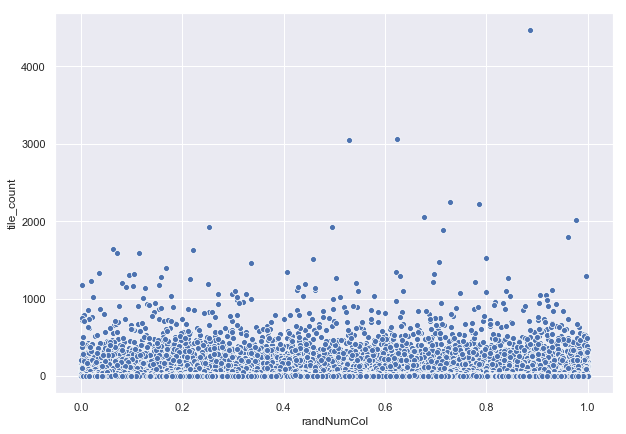

In [36]:
df['randNumCol'] = np.random.sample(len(df))
sns.scatterplot(x = 'randNumCol', y = 'tile_count', data=df)

### As we can see above the random number column has no correlation with our dependent variable. Following this we take the same X and y train test set, but with the random number column added, and initiate the Random Forest model using the same parameters.

In [37]:
X = df[['household_count',
 'population',
 'age_median',
 'land_area',
 'employ_rate',
 'median_household_income',
 'number_of_years_of_education',
 'gini_index',
 'diversity',
 'daily_solar_radiation',
 'occupancy_owner_rate',
 'housing_unit_median_value',
 'voting_2016_dem_percentage',
 'randNumCol']]

y = df.tile_count_D

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [38]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(n_estimators=80,max_depth=9) 

rf.fit(X_train, y_train) 
rf.score(X_test, y_test)

0.8199244844612257

### Following this we use the feature importance function to ascertain which features contribute most significantly to this model.

In [39]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)

In [40]:
feature_importances

,importance
land_area,0.286453
daily_solar_radiation,0.114906
population,0.101052
housing_unit_median_value,0.084879
household_count,0.077958
diversity,0.069032
number_of_years_of_education,0.054421
voting_2016_dem_percentage,0.049891
median_household_income,0.042776
age_median,0.030717


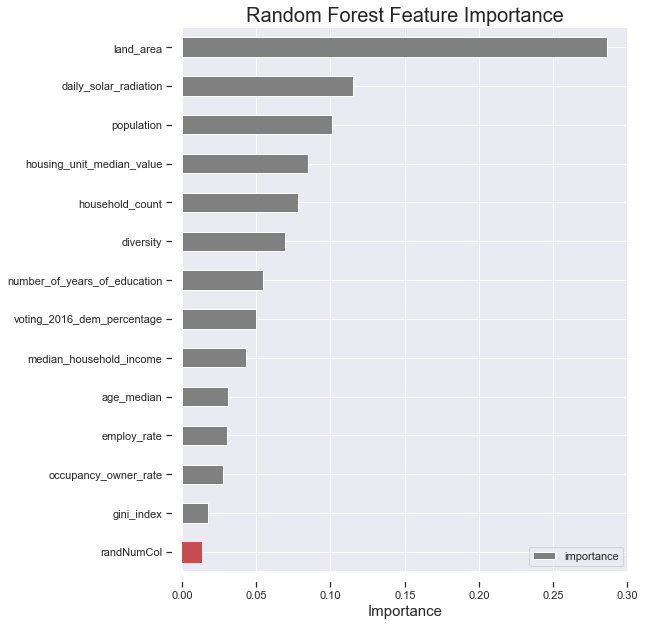

In [41]:
fig, ax = plt.subplots()
feature_importances.plot(kind='barh', ax=ax, figsize=(8,10), color='grey') 
plt.gca().invert_yaxis()
ax.set_title('Random Forest Feature Importance', size=20)
ax.set_xlabel('Importance', size=15)
ax.get_children()[list(feature_importances.index).index('randNumCol')].set_color('r')

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

### Plotting the results of this demonstrates that all features have a greater importance to the model than the random number generated (highlighted in red). By far the most useful feature for model prediction is land area - which is more than twice as important as the the next most important feature. Following land area there are a few other features which stand out, namely: daily solar radiation, population, housing unit median value and household count. To a lesser extent- diversity, number of years of education and democrat voting percentage are also important. However, household income, age, owner occupancy rate and Gini Index have very limited impact on the accuracy of this model. Some of these results are surpising, particularly the results of income, age and owner occupancy rate. Our hypothesis thought more affluent areas would be predictive of solar panel presence, however, given the low importance of these metrics in the model this doesnt appear to be the case. Perhaps, this is due to the fact we are dealing with classification in this instance, and that if looking at levels of solar panels during a regression these features may have a greater affect. Land area then is by far in the way the most important feature for this analysis and would suggest that the lack of solar panels is really dictated by a lack of space. Which makes sense, in cities and other urban areas solar panels are just not feasible.

### One further peice of analysis we were keen to conduct was whether these results held for the state of New York? Given it has such a large urban population in New York City and surrounding affluent suburbs would land area still be the most important classifier for no solar panels?

In [42]:
NY = df.loc[df['state'] == 'ny']

In [43]:
X = NY[[
 'household_count',
 'population',
 'age_median',
 'land_area',
 'employ_rate',
 'median_household_income',
 'number_of_years_of_education',
 'gini_index',
 'diversity',
 'daily_solar_radiation',
 'occupancy_owner_rate',
 'housing_unit_median_value',
 'voting_2016_dem_percentage',
 'randNumCol']]

y = NY.tile_count_D

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [44]:
rf.fit(X_train, y_train).score(X_test, y_test)

feature_importances_NY = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances_NY

,importance
land_area,0.253548
voting_2016_dem_percentage,0.105625
median_household_income,0.081279
occupancy_owner_rate,0.080549
population,0.063990
housing_unit_median_value,0.059157
number_of_years_of_education,0.054471
diversity,0.054030
household_count,0.053747
employ_rate,0.048088


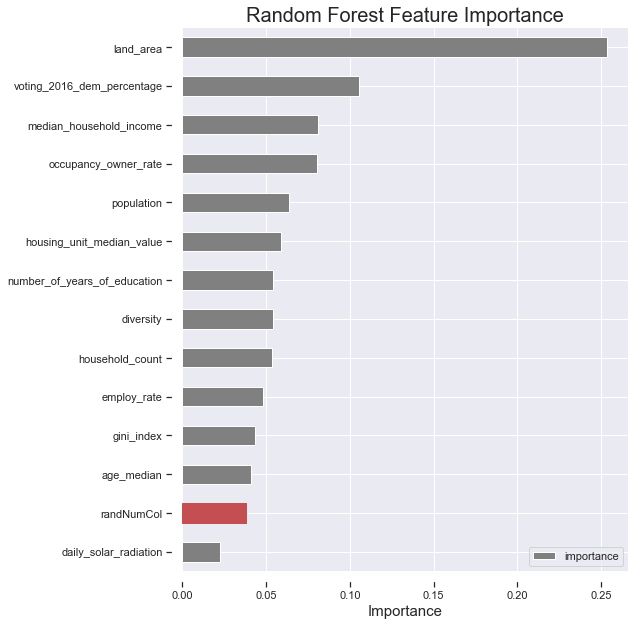

In [45]:
fig, ax = plt.subplots()
feature_importances_NY.plot(kind='barh', ax=ax, figsize=(8,10), color='grey') 
plt.gca().invert_yaxis()
ax.set_title('Random Forest Feature Importance', size=20)
ax.set_xlabel('Importance', size=15)
ax.get_children()[list(feature_importances_NY.index).index('randNumCol')].set_color('r')

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

### The results for New York state are displayed above, and there are some surprising differences. Land area is still the greatest predicting factor for no solar panels, and by some margin, but below this the order of importance shifts significantly. Daily solar radiation, the second most important feature in the state wide analysis, is insignificant for New York state. In fact, it is even less significant than a random number generation, however, is this simply due to a lack of variation in this variable at the state level? Analysis below would suggest that this could be the case, with the variance of the US wide data at 0.32 whereas New York state variance sits at a mere 0.03.

In [46]:
np.var(df['daily_solar_radiation'])

0.32061221242002663

In [47]:
np.var(NY['daily_solar_radiation'])

0.03448660840856695

### The remaining results demonstrate that, Gini Index, age and employment rate are still low on the importance scale, however, Democrat voting percentage, occupancy owner rate, income and education become more important for New York state. We suspect a lot of this could be down to the number of apartments and renters in New York City, clearly if you're renting an apartment you're unable to place solar panels, and this will dictate their presence or not in census tracts. The increased importance of Democrat voting percentage could again be a function of high levels of Democrats in the city areas where minimal solar panel build is present.

### The implications of these results are interesting. They suggest that the greatest limiting factor in the build of solar panels is the size of land area for siting. Regardless of demographic or meteorologic factors, at the end of the day it comes down to the amount of space people have. This analysis however, gives no information about the direction or form of this relationship, something that can be anaylzed further during the next section. ### We will now examine whether these interpretations hold, for regression analysis. Will land area remain the most significant variable if we are predicting number of solar panels as oppose to classifying their absence?

## Regression Analysis

### During this final section, we will attempt to gain a greater understanding as to the key drivers of our dependent variable "tile_count" in regression analysis. For consistency, the same features that were used in the classification will be used here. These features are normalized in order to use their coefficients to demonstrates substantive significance, and t values will be used to demonstrate statistical significance.

In [61]:
reg = smf.ols('tile_count_Z ~ household_count_Z + population_Z + age_median_Z + land_area_Z + employ_rate_Z + median_household_income_Z + number_of_years_of_education_Z + gini_index_Z + diversity_Z + daily_solar_radiation_Z + occupancy_owner_rate_Z + housing_unit_median_value_Z + voting_2016_dem_percentage_Z',data=df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           tile_count_Z   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     1204.
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        18:20:57   Log-Likelihood:                -71275.
No. Observations:               55086   AIC:                         1.426e+05
Df Residuals:                   55072   BIC:                         1.427e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### From the regression output here we can see that land area is no longer the most significant feature. From the statistical sense daily solar radiation is by far the most important predictor of higher levels of the dependent variable. This demonstrates that although land area is important for defining areas of solar absence, it's the levels of solar radiation that more accurately determine the frequency of solar tiles in a particular area. Another key observation is that, unlike in classification, there are a large number of features that have high statistical significance. It appears that the relationships between the dependent and independent variables in our regression are more complex than in classification. 

In [83]:
coef = reg.params

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

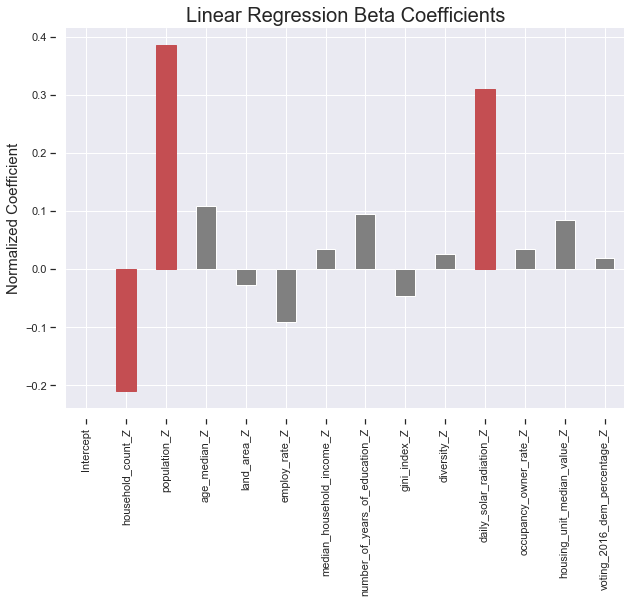

In [87]:
fig, ax = plt.subplots()
reg.params.plot.bar(color="grey")
ax.set_title('Linear Regression Beta Coefficients', size=20)
ax.set_ylabel('Normalized Coefficient', size=15)
ax.get_children()[list(coef.index).index('household_count_Z')].set_color('r')
ax.get_children()[list(coef.index).index('population_Z')].set_color('r')
ax.get_children()[list(coef.index).index('daily_solar_radiation_Z')].set_color('r')

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(rotation=90)

### To analyze susbtantive signficance, the graph above demonstrates the normalized coefficients from the regression analysis. Once more land area is not amongst the most substantive features. Instead population, household count and daily solar radiation have the most substantive effects on our dependent variable. 

### In conclusion, from our classification we found that Random Forest was the most accurate classifier in determining the absence of solar panels from census tracts across the United States and in the New York State. From this analysis it was clear that land area was by far the most important feature for the accuracy of classification. When examining regression, however, these trends change and land area is not the most statistically or substantively significant feature. Instead, daily solar radiation emerges as the most important feature, demonstrating the greatest statistical significance and a t statistic of over 70. It's clear these results barely scratch the surface, of the information and capabilites of this dataset, but they provide an inital indication for policy makers and investors looking to better understand US markets as well as the drivers behind solar panel absence and frequency.